# Setup

In [ ]:
!pip install pytorch_metric_learning
!pip install faiss-gpu
# !pip install faiss-cpu
!pip install umap-learn

     |████████████████████████████████| 102kB 2.9MB/s 
     |████████████████████████████████| 89.4MB 53kB/s 
     |████████████████████████████████| 81kB 3.2MB/s 
     |████████████████████████████████| 1.2MB 27.3MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=cd009d28aed15b34983ddf4da056234b4dd6aa695bde20ab887be90167c2cc37
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=f8f249abb7fa128a0e0846b518cd548090f5a7854d620a91c66745b4ac5834e9
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [ ]:
import umap.umap_ as umap
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from sklearn import decomposition
from itertools import permutations
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from pytorch_metric_learning import losses, miners, reducers, samplers, distances
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering



np.set_printoptions(suppress=True)

In [ ]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu") # shamelessly stolen

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
path = 'gdrive/MyDrive/Programming Projects/Embeddings/data/'

df = pd.read_csv(path + "transactions_train.csv")

In [ ]:
#HYPERPARAMETERS

#Positive pairs generation
SEQUENCE_LEN = 120
SEQUENCES_PER_CLIENT = 10

#Encoder
EVENT_ENCODING_DIMENSIONS = 64
RNN_HIDDEN_STATE_DIMENSIONS = 64
EVENT_EMBEDDING_DIMENSIONS = 16

#Training
EPOCHS = 64
BATCH_SIZE = 64
LEARNING_RATE = 1e-4

#CLUSTERING
NUM_OF_CLUSTERS = 4

CHECKPOINT_PATH = path + "model.pt"

np.random.seed(1871)


# Data

In [ ]:
def subsequence_generator(sequence, pad_vector, to_generate=10, length=120):
    start_idx = np.random.randint(0, len(sequence) - 1, size=to_generate)
    ret = np.tile(pad_vector, (to_generate, length, 1))

    for i, idx in enumerate(start_idx):
        subsequence = sequence[idx:]
        ret[i, 0:subsequence.shape[0]] = subsequence[:min(len(subsequence), length)]

    return ret

In [ ]:
class TransactionDataset(Dataset):
    def __init__(self, df, num_subsequences=10, subsequence_len=120):
        self.clients = df['client_id'].unique()
        
        pad_sequence = np.array([0,0,0.])

        df.loc[:, 'small_group'] = df['small_group'] + 1 # allowing us to use "0" as padding

        self.data = list()
        for i, client in enumerate(self.clients):
            sequence = df[df['client_id'] == client].drop(columns=['client_id']).to_numpy()
            self.data.append(subsequence_generator(sequence, pad_sequence, num_subsequences, subsequence_len))
            
        self.data = np.array(self.data)
        

    def __len__(self):
        return self.clients.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.clients[idx]

In [ ]:
test_clients = np.random.choice(df.client_id.unique(), size=int(0.1 * df.client_id.nunique()))
train_clients = np.array(list(set(df.client_id.unique()) - set(test_clients)))

df_train = df[~df.client_id.isin(test_clients)].copy()
df_test = df[df.client_id.isin(test_clients)].copy()

# takes quite a long time, avoid restarting if possible
train_dataset = TransactionDataset(df_train,
                                   num_subsequences=SEQUENCES_PER_CLIENT,
                                   subsequence_len=SEQUENCE_LEN)


test_dataset = TransactionDataset(df_test,
                                   num_subsequences=SEQUENCES_PER_CLIENT,
                                   subsequence_len=SEQUENCE_LEN)

train_sampler = samplers.MPerClassSampler(train_dataset.clients, 1, batch_size=BATCH_SIZE, length_before_new_iter=len(train_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

test_sampler = samplers.MPerClassSampler(test_dataset.clients, 1, batch_size=BATCH_SIZE, length_before_new_iter=len(test_dataset))

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Encoder


In [ ]:
class EventEncoder(nn.Module):
    def __init__(self, num_features, cat_features, cat_vocab_sizes, out_dim, emb_dim=32):
        super(EventEncoder, self).__init__()

        self.initial_norm = nn.BatchNorm1d(num_features, affine=False)

        # len(nn.ModuleList) is a bit wacky, so we'll store the size just in case
        self.embeddings = nn.ModuleList() 
        self.cat_features = cat_features 
        for i in range(cat_features):
            self.embeddings.append(nn.Embedding(cat_vocab_sizes[i], emb_dim, padding_idx=0))

        cur_size = emb_dim * cat_features + num_features
        self.process = nn.Sequential(
            nn.Linear(cur_size, 64),
            nn.Sigmoid(),
            nn.BatchNorm1d(64),
            nn.Linear(64, out_dim),
            nn.Sigmoid(),
            nn.BatchNorm1d(out_dim),
        )

    def forward(self, numerical, categorical):
        concat_input = self.initial_norm(numerical)

        for i in range(self.cat_features):
            embedded_cat = self.embeddings[i](categorical[:,i])
            concat_input = torch.cat((concat_input, embedded_cat), 1)
        out = self.process(concat_input)
        
        return out

In [ ]:
class SequenceEncoder(nn.Module):
    def __init__(self, num_features, cat_features, cat_vocab_sizes, sequence_len, event_dim=128, hidden_size=128, event_emb_dim=32):

        super(SequenceEncoder, self).__init__()

        self.num_features = num_features
        self.cat_features = cat_features
        self.sequence_len = sequence_len
        self.event_dim = event_dim

        self.event_encoder = EventEncoder(num_features, cat_features, cat_vocab_sizes, event_dim, emb_dim=event_emb_dim)

        self.rnn = nn.GRU(event_dim, hidden_size, batch_first=True)

                     
    def forward(self, numerical, categorical):
        # numerical of size (batch_size, num_of_sequences, sequence_len, num_features)
        # categorical of size (batch_size, num_of_sequences, sequence_len, cat_features)

        numerical = numerical.view(-1, self.num_features)
        categorical = categorical.view(-1, self.cat_features)
        
        # receiving batch_size x num_of_sequences x sequence_len x event_dim events
        events = self.event_encoder(numerical, categorical)
        events = events.view(-1, self.sequence_len, self.event_dim)

        #taking the output of the last cell        
        out = self.rnn(events)[0][:,-1,:]
        
        return out

In [ ]:
encoder = SequenceEncoder(num_features=2, 
                          cat_features=1, 
                          cat_vocab_sizes=[df['small_group'].max() + 1], # +1 for padding 
                          sequence_len=SEQUENCE_LEN, 
                          event_dim=EVENT_ENCODING_DIMENSIONS, 
                          hidden_size=RNN_HIDDEN_STATE_DIMENSIONS,
                          event_emb_dim=EVENT_EMBEDDING_DIMENSIONS)

encoder.to(device)

optimizer = torch.optim.AdamW(encoder.parameters(), lr=LEARNING_RATE)

reduce_func = reducers.AvgNonZeroReducer()
distance_func = distances.LpDistance()
loss_func = losses.TripletMarginLoss(margin=0.3, distance = distance_func, reducer = reduce_func)
miner_func = miners.TripletMarginMiner(margin=0.3, distance = distance_func, type_of_triplets="semihard")

categorical_mask = [False, True, False]

In [ ]:
train_loss_history = list()
val_loss_history = list()


for epoch in tqdm(range(EPOCHS)):
    cur_losses = list()

    encoder.train()
    for batch_idx, (sequences, labels) in enumerate(train_dataloader):
        
        numerical = sequences[:,:,:,np.logical_not(categorical_mask)].to(device)
        categorical = sequences[:,:,:,categorical_mask].to(device)
        
        labels = np.repeat(labels, 10).to(device)

        embeddings = encoder(numerical.float(), categorical.int()).to(device)
        mining = miner_func(embeddings, labels)
        train_loss = loss_func(embeddings, labels, mining)

        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        cur_losses.append(train_loss.item())

    train_loss_history.append(np.mean(cur_losses))

    cur_losses = list()

    encoder.eval()
    for batch_idx, (sequences, labels) in enumerate(test_dataloader):

        numerical = sequences[:,:,:,np.logical_not(categorical_mask)].to(device)
        categorical = sequences[:,:,:,categorical_mask].to(device)

        labels = np.repeat(labels, 10)

        with torch.no_grad():
            embeddings = encoder(numerical.float(), categorical.int()).to(device)
            mining = miner_func(embeddings, labels)
            val_loss = loss_func(embeddings, labels, mining)

            cur_losses.append(val_loss.item())

    val_loss_history.append(np.mean(cur_losses))

    print(" Epoch {}; Train loss = {}; Val loss = {}".format(epoch+1, train_loss_history[-1], val_loss_history[-1]))

    torch.save({
            'epoch': epoch,
            'model_state_dict': encoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_history[-1],
            }, CHECKPOINT_PATH)

  2%|▏         | 1/64 [00:37<39:35, 37.70s/it]

Epoch 0; Train loss = 0.1594160099707122; Val loss = 0.15955938297239217


  3%|▎         | 2/64 [01:14<38:34, 37.34s/it]

Epoch 1; Train loss = 0.1518568186757137; Val loss = 0.14626253971999342


  5%|▍         | 3/64 [01:50<37:37, 37.01s/it]

Epoch 2; Train loss = 0.14296399411868374; Val loss = 0.1412833576852625


  6%|▋         | 4/64 [02:26<36:48, 36.82s/it]

Epoch 3; Train loss = 0.1411454292400828; Val loss = 0.14156851443377408


  8%|▊         | 5/64 [03:03<36:04, 36.68s/it]

Epoch 4; Train loss = 0.14067406326813517; Val loss = 0.14151652699167078


  9%|▉         | 6/64 [03:39<35:22, 36.60s/it]

Epoch 5; Train loss = 0.14036723637496526; Val loss = 0.14006703076037494


 11%|█         | 7/64 [04:15<34:40, 36.51s/it]

Epoch 6; Train loss = 0.13996350023684637; Val loss = 0.13974994251673872


 12%|█▎        | 8/64 [04:52<34:00, 36.44s/it]

Epoch 7; Train loss = 0.1395395993132074; Val loss = 0.13951569964939897


 14%|█▍        | 9/64 [05:28<33:21, 36.40s/it]

Epoch 8; Train loss = 0.13923685706027275; Val loss = 0.1394274407489733


 16%|█▌        | 10/64 [06:04<32:43, 36.36s/it]

Epoch 9; Train loss = 0.13902522690313043; Val loss = 0.13938451998613097


 17%|█▋        | 11/64 [06:40<32:01, 36.25s/it]

Epoch 10; Train loss = 0.13881666982933036; Val loss = 0.13886146179654382


 19%|█▉        | 12/64 [07:16<31:20, 36.17s/it]

Epoch 11; Train loss = 0.1386982733559496; Val loss = 0.1384205645458265


 20%|██        | 13/64 [07:52<30:41, 36.10s/it]

Epoch 12; Train loss = 0.13844262720700704; Val loss = 0.13879506493156607


 22%|██▏       | 14/64 [08:28<30:01, 36.04s/it]

Epoch 13; Train loss = 0.13823046587969898; Val loss = 0.1382870657200163


 23%|██▎       | 15/64 [09:04<29:26, 36.05s/it]

Epoch 14; Train loss = 0.13795759490216677; Val loss = 0.13783477653156628


 25%|██▌       | 16/64 [09:40<28:48, 36.01s/it]

Epoch 15; Train loss = 0.13774788924405035; Val loss = 0.1378279555250298


 27%|██▋       | 17/64 [10:16<28:12, 36.02s/it]

Epoch 16; Train loss = 0.13727838008330678; Val loss = 0.1374972682784904


 28%|██▊       | 18/64 [10:52<27:37, 36.03s/it]

Epoch 17; Train loss = 0.13617936592057067; Val loss = 0.13559358702464538


 30%|██▉       | 19/64 [11:28<27:02, 36.06s/it]

Epoch 18; Train loss = 0.13442162322407625; Val loss = 0.1337036636065353


 31%|███▏      | 20/64 [12:04<26:29, 36.12s/it]

Epoch 19; Train loss = 0.13354823552072048; Val loss = 0.13339841264215382


 33%|███▎      | 21/64 [12:41<25:52, 36.11s/it]

Epoch 20; Train loss = 0.13312596652024197; Val loss = 0.13307471200823784


 34%|███▍      | 22/64 [13:17<25:18, 36.16s/it]

Epoch 21; Train loss = 0.13278287863534577; Val loss = 0.13246393136002801


 36%|███▌      | 23/64 [13:53<24:42, 36.16s/it]

Epoch 22; Train loss = 0.132181626270121; Val loss = 0.13210925459861755


 38%|███▊      | 24/64 [14:29<24:06, 36.17s/it]

Epoch 23; Train loss = 0.13121226725150953; Val loss = 0.13035915317860516


 39%|███▉      | 25/64 [15:05<23:29, 36.14s/it]

Epoch 24; Train loss = 0.1299510482558102; Val loss = 0.1288229894231666


 41%|████      | 26/64 [15:41<22:50, 36.07s/it]

Epoch 25; Train loss = 0.12924106898805443; Val loss = 0.12873221629045226


 42%|████▏     | 27/64 [16:17<22:13, 36.04s/it]

Epoch 26; Train loss = 0.12872157713292903; Val loss = 0.12796191989698194


 44%|████▍     | 28/64 [16:53<21:35, 35.99s/it]

Epoch 27; Train loss = 0.12805886578939432; Val loss = 0.12734374844215132


 45%|████▌     | 29/64 [17:29<21:01, 36.04s/it]

Epoch 28; Train loss = 0.12731394336892748; Val loss = 0.12627370994199405


 47%|████▋     | 30/64 [18:05<20:24, 36.02s/it]

Epoch 29; Train loss = 0.12650345235992716; Val loss = 0.12593492594632236


 48%|████▊     | 31/64 [18:41<19:49, 36.05s/it]

Epoch 30; Train loss = 0.1254265160247121; Val loss = 0.12470406869595702


 50%|█████     | 32/64 [19:17<19:12, 36.01s/it]

Epoch 31; Train loss = 0.12442779054267789; Val loss = 0.12394158372824843


 52%|█████▏    | 33/64 [19:53<18:34, 35.96s/it]

Epoch 32; Train loss = 0.12374153935332906; Val loss = 0.12312029132788832


 53%|█████▎    | 34/64 [20:29<17:57, 35.92s/it]

Epoch 33; Train loss = 0.12321430400787096; Val loss = 0.12266961959275333


 55%|█████▍    | 35/64 [21:05<17:20, 35.88s/it]

Epoch 34; Train loss = 0.12311413812117195; Val loss = 0.12297113239765167


 56%|█████▋    | 36/64 [21:40<16:44, 35.86s/it]

Epoch 35; Train loss = 0.12284867456710001; Val loss = 0.1229307483881712


 58%|█████▊    | 37/64 [22:16<16:06, 35.79s/it]

Epoch 36; Train loss = 0.122642362297003; Val loss = 0.12326398407193748


 59%|█████▉    | 38/64 [22:52<15:30, 35.77s/it]

Epoch 37; Train loss = 0.12245511323354154; Val loss = 0.12202378887344491


 61%|██████    | 39/64 [23:27<14:53, 35.72s/it]

Epoch 38; Train loss = 0.12232970678300228; Val loss = 0.12256065552884882


 62%|██████▎   | 40/64 [24:03<14:16, 35.67s/it]

Epoch 39; Train loss = 0.12208554795328176; Val loss = 0.12191790901124477


 64%|██████▍   | 41/64 [24:39<13:39, 35.62s/it]

Epoch 40; Train loss = 0.12178464056396822; Val loss = 0.12198632007295435


 66%|██████▌   | 42/64 [25:14<13:03, 35.62s/it]

Epoch 41; Train loss = 0.12161395111876838; Val loss = 0.12140034697949886


 67%|██████▋   | 43/64 [25:50<12:28, 35.66s/it]

Epoch 42; Train loss = 0.12142018808649396; Val loss = 0.12195772677659988


 69%|██████▉   | 44/64 [26:25<11:52, 35.61s/it]

Epoch 43; Train loss = 0.12131122153533518; Val loss = 0.12117840603671291


 70%|███████   | 45/64 [27:01<11:16, 35.58s/it]

Epoch 44; Train loss = 0.12126499149104897; Val loss = 0.12106030214239251


 72%|███████▏  | 46/64 [27:36<10:39, 35.55s/it]

Epoch 45; Train loss = 0.120891536357549; Val loss = 0.12108348682522774


 73%|███████▎  | 47/64 [28:12<10:03, 35.51s/it]

Epoch 46; Train loss = 0.12049764997483987; Val loss = 0.12068356624381109


 75%|███████▌  | 48/64 [28:47<09:28, 35.52s/it]

Epoch 47; Train loss = 0.12057582310067033; Val loss = 0.12085563791069118


 77%|███████▋  | 49/64 [29:23<08:52, 35.49s/it]

Epoch 48; Train loss = 0.12035592334380127; Val loss = 0.12010856819423762


 78%|███████▊  | 50/64 [29:58<08:17, 35.50s/it]

Epoch 49; Train loss = 0.12022829797329768; Val loss = 0.12009914388710802


 80%|███████▉  | 51/64 [30:34<07:41, 35.48s/it]

Epoch 50; Train loss = 0.11978016667208581; Val loss = 0.11956217495555227


 81%|████████▏ | 52/64 [31:09<07:05, 35.49s/it]

Epoch 51; Train loss = 0.11990409421752084; Val loss = 0.12002739208665761


 83%|████████▎ | 53/64 [31:45<06:29, 35.45s/it]

Epoch 52; Train loss = 0.11967715794958596; Val loss = 0.12059651704674418


 84%|████████▍ | 54/64 [32:20<05:54, 35.41s/it]

Epoch 53; Train loss = 0.11961030666628536; Val loss = 0.12013043615628373


 86%|████████▌ | 55/64 [32:55<05:18, 35.40s/it]

Epoch 54; Train loss = 0.11949327760288175; Val loss = 0.11887853575701063


 88%|████████▊ | 56/64 [33:31<04:43, 35.38s/it]

Epoch 55; Train loss = 0.11943362623382851; Val loss = 0.12063899957998232


 89%|████████▉ | 57/64 [34:06<04:07, 35.39s/it]

Epoch 56; Train loss = 0.1194057277280767; Val loss = 0.11998031406917355


 91%|█████████ | 58/64 [34:41<03:32, 35.38s/it]

Epoch 57; Train loss = 0.11928565800189972; Val loss = 0.11899487691169436


 92%|█████████▏| 59/64 [35:17<02:56, 35.37s/it]

Epoch 58; Train loss = 0.11915125418454409; Val loss = 0.11872824755581943


 94%|█████████▍| 60/64 [35:52<02:21, 35.32s/it]

Epoch 59; Train loss = 0.1192702772447242; Val loss = 0.11937322789295153


 95%|█████████▌| 61/64 [36:27<01:45, 35.28s/it]

Epoch 60; Train loss = 0.11908450077797444; Val loss = 0.11987269449640404


 97%|█████████▋| 62/64 [37:02<01:10, 35.29s/it]

Epoch 61; Train loss = 0.11896058331893862; Val loss = 0.11925393393771215


 98%|█████████▊| 63/64 [37:38<00:35, 35.25s/it]

Epoch 62; Train loss = 0.11893775751638525; Val loss = 0.11909291588447311


100%|██████████| 64/64 [38:13<00:00, 35.83s/it]

Epoch 63; Train loss = 0.11900986256605049; Val loss = 0.11852096156640486


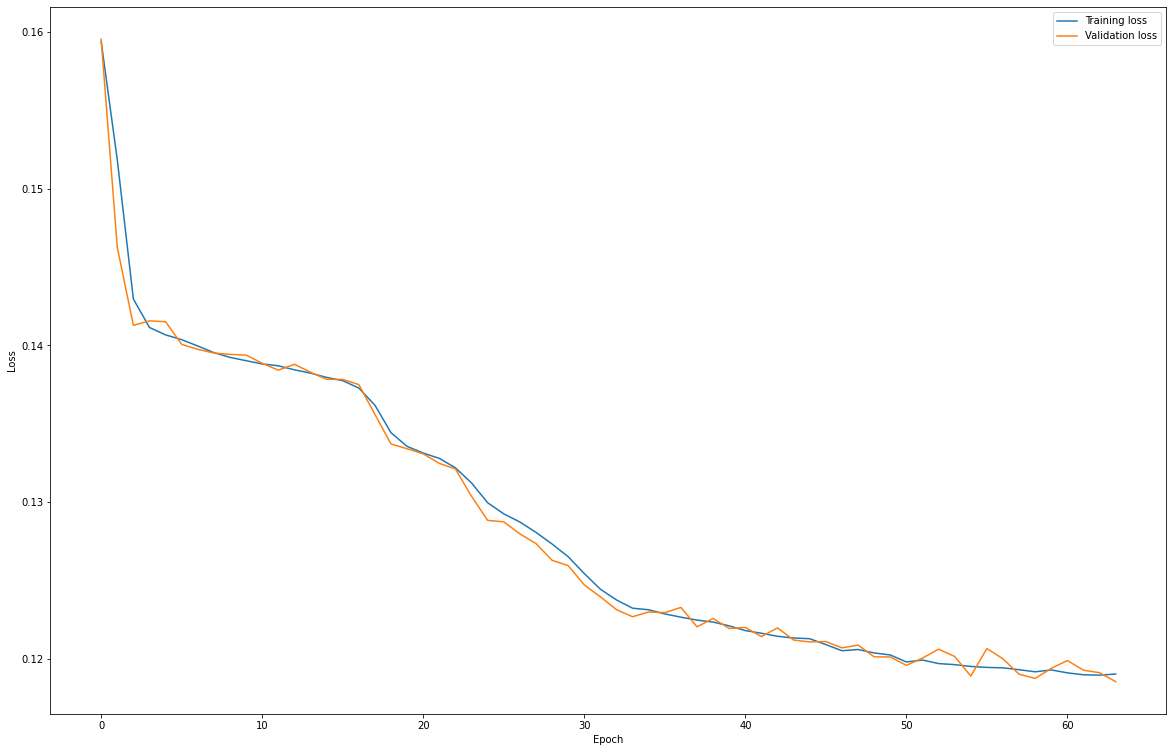

In [ ]:
plt.figure(figsize=(20,13))

plt.plot(train_loss_history, label='Training loss')
plt.plot(val_loss_history, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Clustering

In [ ]:
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
encoder.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [ ]:
y = pd.read_csv(path + "train_target.csv")  
client_target_dict = pd.Series(y.bins.values, index=y.client_id).to_dict()
age_target = np.vectorize(client_target_dict.get)(train_clients)

In [ ]:
predict_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=SequentialSampler(train_dataset))

pred = np.zeros(shape=(len(train_clients), SEQUENCES_PER_CLIENT, RNN_HIDDEN_STATE_DIMENSIONS))
client_targets = np.zeros(shape=len(train_clients))
age_targets = np.zeros(shape=len(train_clients))

encoder.eval()
for batch_idx, (sequences, labels) in enumerate(predict_dataloader):
    numerical = sequences[:,:,:,np.logical_not(categorical_mask)].to(device)
    categorical = sequences[:,:,:,categorical_mask].to(device)
    labels = labels.numpy()

    with torch.no_grad():
        embeddings = encoder(numerical.float(), categorical.int()).to(device)
    embeddings = embeddings.view(-1, SEQUENCES_PER_CLIENT, RNN_HIDDEN_STATE_DIMENSIONS)

    pred[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE, :, :] = embeddings.cpu().numpy()
    client_targets[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE] = labels
    age_targets[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE] = np.vectorize(client_target_dict.get)(labels)

In [ ]:
pred = pred.reshape(-1, RNN_HIDDEN_STATE_DIMENSIONS)
client_targets = np.repeat(client_targets, SEQUENCES_PER_CLIENT)
age_targets = np.repeat(age_targets, SEQUENCES_PER_CLIENT)

pickle.dump(pred, open(path + "pred.p", "wb" ) )
pickle.dump(client_targets, open(path + "client_targets.p", "wb" ) )
pickle.dump(age_targets, open(path + "age_targets.p", "wb" ) )


In [ ]:
pred = pickle.load(open(path + "pred.p", "rb" ))
client_targets = pickle.load(open(path + "client_targets.p", "rb" ))
age_targets = pickle.load(open(path + "age_targets.p", "rb" ))

In [ ]:
# emb_2d_00 = umap.UMAP(n_neighbors=75, min_dist=0.0).fit_transform(pred)

emb_2d_25 = umap.UMAP(n_neighbors=75, min_dist=0.25).fit_transform(pred)

# emb_2d_50 = umap.UMAP(n_neighbors=75, min_dist=0.5).fit_transform(pred)

# pickle.dump(emb_2d, open(path + "75neighbours.p", "wb" ) )

No handles with labels found to put in legend.


[]

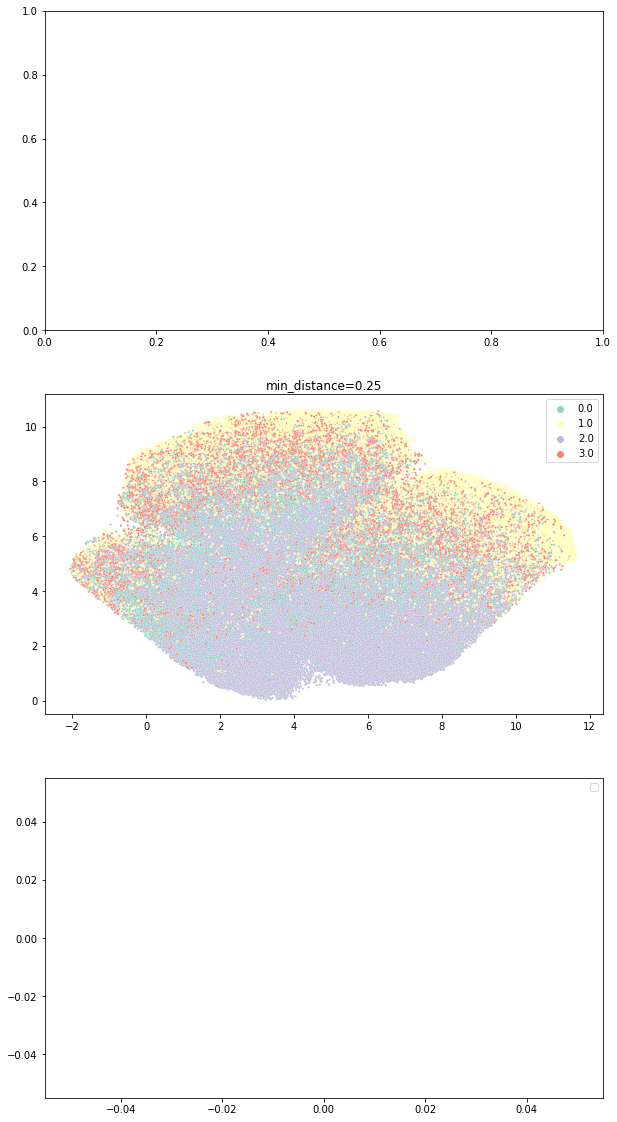

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 20))
# axs[0].set_title('min_distance=0.0')
# sns.scatterplot(ax=axs[0], x=emb_2d_00[:,0], y=emb_2d_00[:,1], hue=age_targets, s=5, palette="Set3")
axs[1].set_title('min_distance=0.25')
sns.scatterplot(ax=axs[1], x=emb_2d_25[:,0], y=emb_2d_25[:,1], hue=age_targets, s=5, palette="Set3")
# axs[2].set_title('min_distance=0.5')
# sns.scatterplot(ax=axs[2], x=emb_2d_50[:,0], y=emb_2d_50[:,1], hue=age_targets, s=5, palette="Set3")

plt.legend()
plt.plot()

In [ ]:
pca = decomposition.PCA(n_components=2)

pca_data = pca.fit_transform(pred)

[]

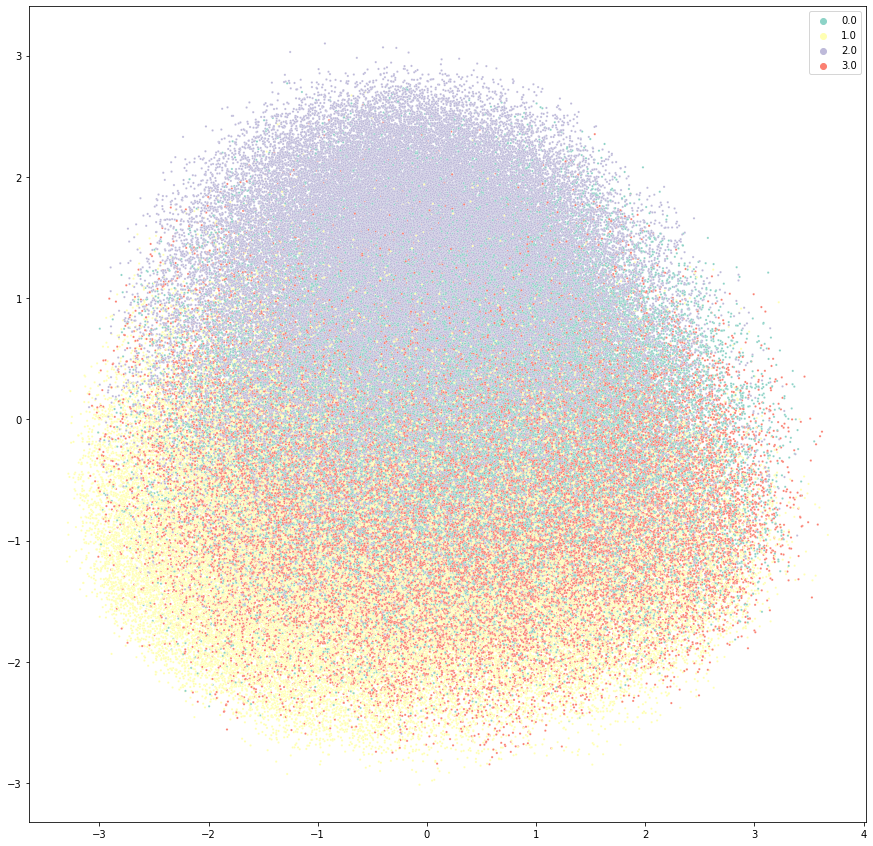

In [ ]:
plt.figure(figsize=(15,15))
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=age_targets, s=5, palette="Set3")
plt.plot()

In [ ]:
def clustering_accuracy(y_true, y_pred):
    max_acc = 0
    true_pred = np.zeros(len(y_pred))
    for permutation in permutations(range(len(np.unique(y_true)))):
        permutation_dict = {k: v for k, v in enumerate(permutation)}
        accuracy = accuracy_score(y_true, np.vectorize(permutation_dict.get)(y_pred))
        if accuracy > max_acc:
            max_acc = accuracy
            true_pred = y_pred.copy()
    return max_acc, true_pred

In [ ]:
kmeans = KMeans(n_clusters=NUM_OF_CLUSTERS, 
                algorithm='full', 
                tol=1e-3)

kmeans_res = kmeans.fit(pred)

print(clustering_accuracy(age_targets, res.labels_))

0.44988576061320756


In [ ]:
# Murders RAM

# spectral = SpectralClustering(n_clusters=NUM_OF_CLUSTERS, 
#                               eigen_solver='arpack', 
#                               affinity='rbf')

# spectral_res = spectral.fit(pred)

# print(clustering_accuracy(age_targets, res.labels_))

In [ ]:
agglomerative = AgglomerativeClustering()

NameError: ignored

Accuracy: 0.45007370283018866


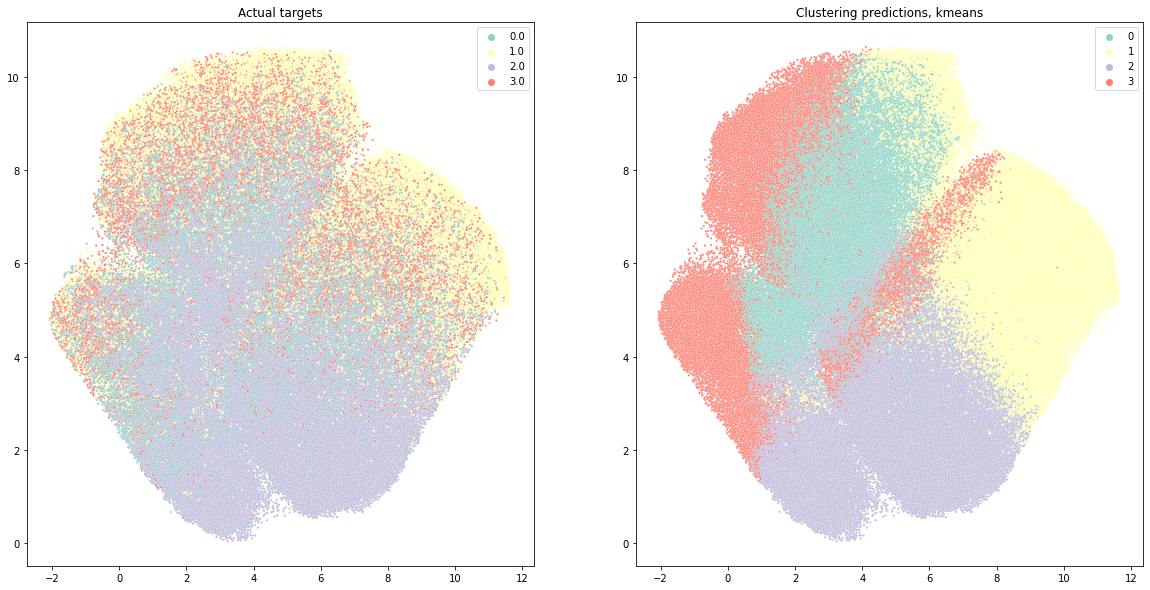

In [ ]:
accuracy, labels = clustering_accuracy(age_targets, res.labels_)

print('Accuracy: {}'.format(accuracy))

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].set_title('Actual targets')
sns.scatterplot(ax=axs[0], x=emb_2d_25[:,0], y=emb_2d_25[:,1], hue=age_targets, s=5, palette="Set3")
axs[1].set_title('Clustering predictions, kmeans')
sns.scatterplot(ax=axs[1], x=emb_2d_25[:,0], y=emb_2d_25[:,1], hue=labels, s=5, palette="Set3")